Ekstraksi fitur indeks: 100%|██████████| 14034/14034 [00:45<00:00, 309.73it/s]


Query dipilih: query/street\2.jpg


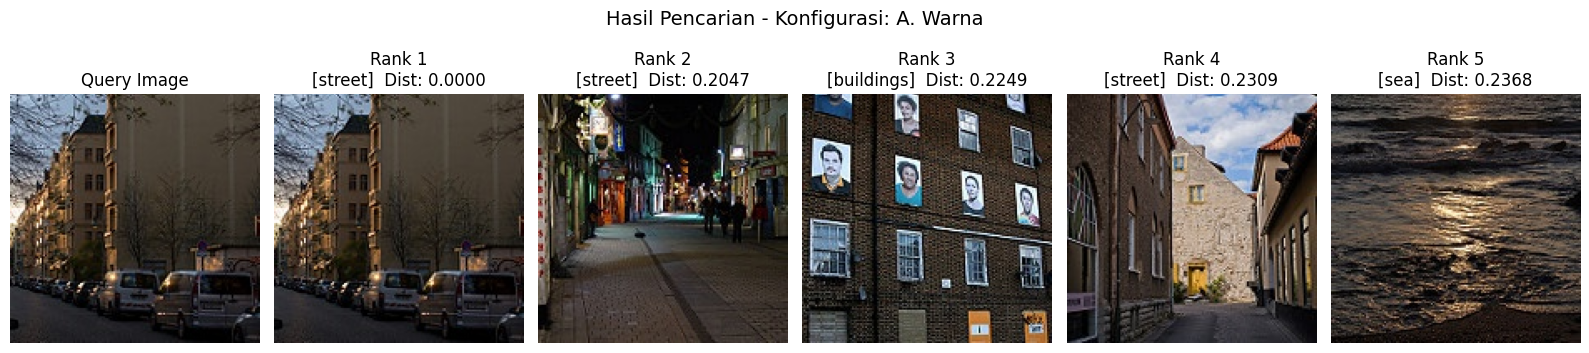

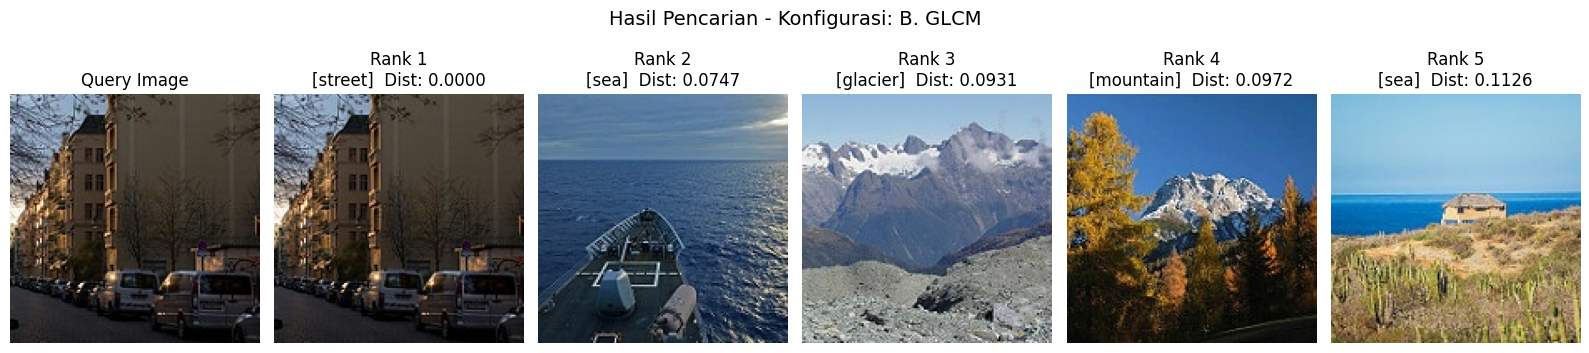

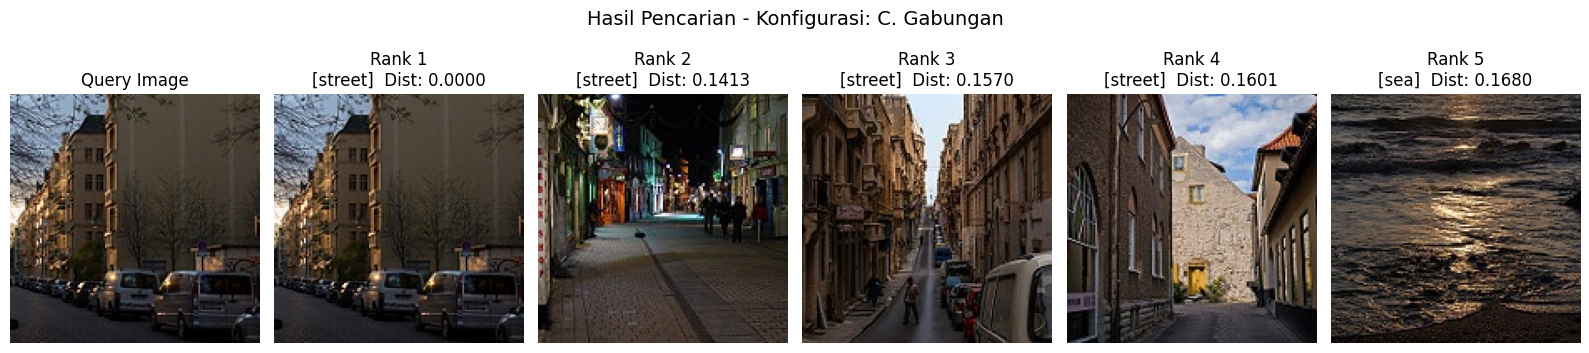

In [3]:
# ==========================
# CBIR (semua subfolder db/, query di db/query)
# ==========================
import os, cv2, numpy as np, matplotlib.pyplot as plt, random
from tqdm import tqdm
from scipy.spatial.distance import cosine
from skimage.feature import graycomatrix, graycoprops

# ---------- Konfigurasi ----------
DB_ROOT     = "db"
QUERY_DIR   = "query/street"
TOPK        = 5
SEED        = 42
W_COLOR     = 0.6
W_GLCM      = 0.4

random.seed(SEED)
np.random.seed(SEED)

# ---------- Utilitas I/O ----------
def is_image(fname):
    exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
    return fname.lower().endswith(exts)

def imread_rgb(path):
    bgr = cv2.imread(path, cv2.IMREAD_COLOR)
    if bgr is None:
        raise FileNotFoundError(f"Gagal membaca: {path}")
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

def to_gray_uint8(rgb):
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    return np.clip(gray, 0, 255).astype(np.uint8)

def walk_index_paths(db_root, exclude_dirs=('query',)):
    """
    Ambil SEMUA gambar dari semua subfolder db_root KECUALI folder dalam exclude_dirs.
    Mengembalikan:
      - paths: list path gambar
      - labels: list label (nama folder induk)
    """
    paths, labels = [], []
    for root, dirs, files in os.walk(db_root):
        # ambil nama folder terakhir
        last = os.path.basename(root)
        if last.lower() in {d.lower() for d in exclude_dirs}:
            continue
        for f in files:
            if is_image(f):
                p = os.path.join(root, f)
                paths.append(p)
                labels.append(os.path.basename(root))
    if not paths:
        raise FileNotFoundError(f"Tidak menemukan gambar untuk indeks di: {db_root}")
    # urutkan agar stabil
    idx = np.argsort(paths)
    paths = [paths[i] for i in idx]
    labels = [labels[i] for i in idx]
    return paths, labels

def list_query_images(db_root, query_dir='query'):
    qroot = query_dir
    if not os.path.isdir(qroot):
        raise FileNotFoundError(f"Folder query tidak ditemukan: {qroot}")
    qpaths = [os.path.join(qroot, f) for f in os.listdir(qroot) if is_image(f)]
    if not qpaths:
        raise FileNotFoundError(f"Tidak ada gambar di folder query: {qroot}")
    qpaths.sort()
    return qpaths

# ---------- Jarak ----------
def chi2_distance(h1, h2, eps=1e-10):
    return 0.5 * np.sum(((h1 - h2) ** 2) / (h1 + h2 + eps))

def l2_distance(x, y):
    return float(np.linalg.norm(x - y))

# ---------- Fitur ----------
def hsv_hist_feature(rgb, bins=(8,8,8)):
    hsv  = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
    hist = cv2.calcHist([hsv], [0,1,2], None, bins, [0,180, 0,256, 0,256])
    hist = hist.flatten().astype(np.float32)
    hist /= (hist.sum() + 1e-8)
    return hist

def glcm_feature(rgb, levels=16, distances=(1,2,3), angles=(0, np.pi/4, np.pi/2, 3*np.pi/4)):
    gray8 = to_gray_uint8(rgb)
    # kuantisasi 0..255 -> 0..levels-1
    q = (gray8.astype(np.float32) * (levels / 256.0)).astype(np.uint8)
    q = np.clip(q, 0, levels-1)

    glcm = graycomatrix(q, distances=distances, angles=angles,
                        levels=levels, symmetric=True, normed=True)
    props = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']
    feats = []
    for p in props:
        v = graycoprops(glcm, p)   # shape: (len(d), len(a))
        feats.append(v.mean())
        feats.append(v.std())
    return np.array(feats, dtype=np.float32)

# ---------- Indexing ----------
def build_index(paths):
    color_feats, glcm_feats = [], []
    for p in tqdm(paths, desc="Ekstraksi fitur indeks"):
        rgb = imread_rgb(p)
        color_feats.append(hsv_hist_feature(rgb))
        glcm_feats.append(glcm_feature(rgb))
    return np.array(color_feats), np.array(glcm_feats)

# ---------- Retrieval ----------
def search_color(qc, color_index, k=5):
    d = np.array([chi2_distance(qc, f) for f in color_index], dtype=np.float32)
    order = np.argsort(d)[:k]
    return order, d[order]

def search_glcm(qg, glcm_index, k=5):
    d = np.array([l2_distance(qg, f) for f in glcm_index], dtype=np.float32)
    order = np.argsort(d)[:k]
    return order, d[order]

def search_combined(qc, qg, color_index, glcm_index, k=5, w_color=0.6, w_glcm=0.4):
    dc = np.array([chi2_distance(qc, f) for f in color_index], dtype=np.float32)
    dg = np.array([l2_distance(qg, f) for f in glcm_index], dtype=np.float32)

    # min-max scaling supaya skala setara
    def mm(x):
        mn, mx = float(np.min(x)), float(np.max(x))
        if mx - mn < 1e-12: return np.zeros_like(x)
        return (x - mn) / (mx - mn)

    score = w_color * mm(dc) + w_glcm * mm(dg)
    order = np.argsort(score)[:k]
    return order, score[order]

# ---------- Visualisasi ----------
def show_results(title, query_img, ranked_idx, all_paths, all_labels, dists, save_path=None):
    K = len(ranked_idx)
    plt.figure(figsize=(16,4))
    plt.suptitle(title, fontsize=14)
    # query
    plt.subplot(1, K+1, 1)
    plt.imshow(query_img); plt.axis('off'); plt.title("Query Image")
    # ranks
    for i, (rid, dist) in enumerate(zip(ranked_idx, dists), start=2):
        p = all_paths[rid]; lbl = all_labels[rid]
        plt.subplot(1, K+1, i)
        plt.imshow(imread_rgb(p)); plt.axis('off')
        plt.title(f"Rank {i-1}\n[{lbl}]  Dist: {dist:.4f}")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=180, bbox_inches="tight")
    plt.show()

# ==========================
# MAIN
# ==========================
# 1) Kumpulkan semua gambar indeks dari SEMUA subfolder db/ kecuali db/query/
index_paths, index_labels = walk_index_paths(DB_ROOT, exclude_dirs=(QUERY_DIR,))

# 2) Build index (warna & glcm)
color_index, glcm_index = build_index(index_paths)

# 3) Ambil query (acak dari db/query, atau set manual: QUERY_PATH = "db/query/nama.jpg")
query_list = list_query_images(DB_ROOT, QUERY_DIR)
QUERY_PATH = random.choice(query_list)   # random
print(f"Query dipilih: {QUERY_PATH}")

q_rgb   = imread_rgb(QUERY_PATH)
q_color = hsv_hist_feature(q_rgb)
q_glcm  = glcm_feature(q_rgb)

# 4) A. Warna
idxA, distA = search_color(q_color, color_index, k=TOPK)
show_results("Hasil Pencarian - Konfigurasi: A. Warna", q_rgb, idxA, index_paths, index_labels, distA)

# 5) B. GLCM
idxB, distB = search_glcm(q_glcm, glcm_index, k=TOPK)
show_results("Hasil Pencarian - Konfigurasi: B. GLCM", q_rgb, idxB, index_paths, index_labels, distB)

# 6) C. Gabungan
idxC, distC = search_combined(q_color, q_glcm, color_index, glcm_index,
                              k=TOPK, w_color=W_COLOR, w_glcm=W_GLCM)
show_results("Hasil Pencarian - Konfigurasi: C. Gabungan", q_rgb, idxC, index_paths, index_labels, distC)
